
# Forward Sensitivity Analysis for the Lotka–Volterra System

This notebook performs parameter estimation for the Lotka–Volterra model using the **forward sensitivity method**.

We:
- Load noisy synthetic observations.
- Solve the ODE system with sensitivities ∂s/∂p.
- Define the cost function and its gradient.
- Use these in optimization to identify the parameters.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm



##  Upload Observations

Upload your `Data_Ex_Assimilation.npz` file generated from the previous notebook.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load it from the same folder
data = np.load('/content/drive/MyDrive/data_exercise_adjoint_ULB.npz')
t_obs = data['t']
s_obs = data['s_noisy'].T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Initial condition for state
s0 = np.array([10, 5])

def augmented_system(t, y_aug, p):
    a, b, c, d = p # define the parameter
    s1, s2 = y_aug[0], y_aug[1]
    S = y_aug[2:].reshape(4, 2)  # sensitivities shape (4, 2)

    # Original system
    ds1_dt = a * s1 - b * s1 * s2
    ds2_dt = -c * s2 + d * s1 * s2

    # Jacobian ∂f/∂s
    J_s = np.array([
        [a - b * s2, -b * s1],
        [d * s2, -c + d * s1]
    ])

    # ∂f/∂p terms
    df_dp = np.array([
        [s1, -s1 * s2, 0, 0],
        [0, 0, -s2, s1 * s2]
    ]).T  # shape (4, 2)

    dSdt = np.array([J_s @ S[i] + df_dp[i] for i in range(4)])
    return np.concatenate([[ds1_dt, ds2_dt], dSdt.flatten()])


In [ ]:
def cost_and_gradient(p, s0=s0, t_obs=t_obs, s_obs=s_obs):
    S0 = np.zeros((4, 2)) # initialize sensitivities
    y0_aug = np.concatenate([s0, S0.flatten()]) # concatenate state and sensitivity

    # solve the augmented system forward !
    sol = solve_ivp(lambda t, y: augmented_system(t, y, p),
                    [t_obs[0], t_obs[-1]],
                    y0_aug,
                    t_eval=t_obs,
                    method='RK23')

    s_model = sol.y[:2].T
    sens = sol.y[2:].T.reshape(-1, 4, 2)

    residuals = s_model - s_obs
    J = np.sum(residuals ** 2)/len(residuals)

    grad_J = np.zeros(4)
    for j in range(4):
        for t in range(len(t_obs)):
            grad_J[j] += 2 * residuals[t] @ sens[t, j]

    grad_J/=len(residuals)
    return J, grad_J

# function to evaluate the gradient via finite difference
def finite_difference_gradient(cost_fn, p, epsilon=1e-6):
    """
    Compute gradient via centered finite differences.

    Parameters:
        cost_fn : function
            Function that returns only the scalar cost.
        p : ndarray
            Current parameter vector.
        epsilon : float
            Perturbation size.

    Returns:
        grad_fd : ndarray
            Finite difference approximation to the gradient.
    """
    grad_fd = np.zeros_like(p)
    for i in range(len(p)):
        p_plus = p.copy()
        p_minus = p.copy()
        p_plus[i] += epsilon
        p_minus[i] -= epsilon
        J_plus, _ = cost_and_gradient(p_plus)
        J_minus, _ = cost_and_gradient(p_minus)
        grad_fd[i] = (J_plus - J_minus) / (2 * epsilon)
    return grad_fd



# double check the gradient and compare with finite differences


p_test = np.array([1.2, 1.4, 3.4, 1.2])
_, grad_analytic = cost_and_gradient(p_test)
grad_fd = finite_difference_gradient(lambda p: cost_and_gradient(p)[0], p_test)

print("Analytic gradient:     ", grad_analytic)
print("Finite diff gradient:  ", grad_fd)
print("Difference in relative norm (%):       ",
      np.linalg.norm(grad_analytic - grad_fd)/np.linalg.norm(grad_analytic)*100)





Analytic gradient:      [130.47644538 -36.4719222   46.52134029 -72.57858338]
Finite diff gradient:   [130.60043652 -36.4617819   46.53256279 -72.28187007]
Difference in relative norm (%):        0.20048087943024964


In [ ]:
def adam_optimize(func, x0, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iter=1000, tol=1e-6, **kwargs):
    """
    ADAM optimization to minimize a callable function with a cost and gradient.

    Parameters:
    -----------
    func : callable
        A function that returns a tuple (J(x), grad J(x)), where J is the cost and grad J is the gradient.

    x0 : numpy array
        Initial guess for the parameter vector.

    lr : float
        Learning rate for the ADAM optimizer.

    beta1 : float
        Exponential decay rate for the first moment estimate.

    beta2 : float
        Exponential decay rate for the second moment estimate.

    epsilon : float
        Small constant to avoid division by zero.

    max_iter : int
        Maximum number of iterations.

    tol : float
        Tolerance for convergence.

    **kwargs : dict
        Extra arguments passed to the function `func(x, **kwargs)`.

    Returns:
    --------
    result : dict
        Dictionary containing:
            - x: Final optimized parameters
            - final_cost: Cost at the solution
            - iterations: Number of iterations performed
            - converged: Whether convergence criterion was met
            - history: Dictionary with 'costs' and 'parameters' over iterations
    """
    x = np.array(x0, dtype=np.float64)
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    t = 0  # iteration counter

    history = {
        "costs": [],
        "parameters": []
    }

    for _ in tqdm(range(max_iter), desc="Optimizing with ADAM"):
        t += 1
        J, grad = func(x, **kwargs)
        history["costs"].append(J)
        history["parameters"].append(x.copy())

        # Update biased moment estimates
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        # Bias correction
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        # Update parameters
        x_prev = x
        x = x - lr * m_hat / (np.sqrt(v_hat) + epsilon)

        # Check convergence
        if np.linalg.norm(x - x_prev) < tol:
            return {
                "x": x,
                "final_cost": J,
                "iterations": t,
                "converged": True,
                "history": history
            }

    return {
        "x": x,
        "final_cost": J,
        "iterations": max_iter,
        "converged": False,
        "history": history
    }


In [ ]:
# Initial guess (intentionally incorrect)
p0 = np.array([1.2, 1.4, 3.4, 1.2])
result = adam_optimize(cost_and_gradient, x0=p0,lr=0.05,max_iter=500)
print("Estimated parameters:", result["x"])
p_opt = result["x"] # assign the result to p_opt

Optimizing with ADAM: 100%|██████████| 500/500 [00:42<00:00, 11.77it/s]

Estimated parameters: [0.91168542 0.89979081 3.19430509 1.0079557 ]


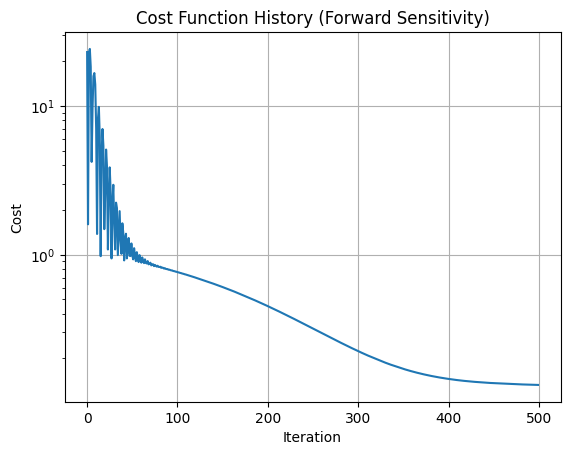

In [ ]:
plt.plot(result["history"]["costs"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function History (Forward Sensitivity)")
plt.grid(True)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()


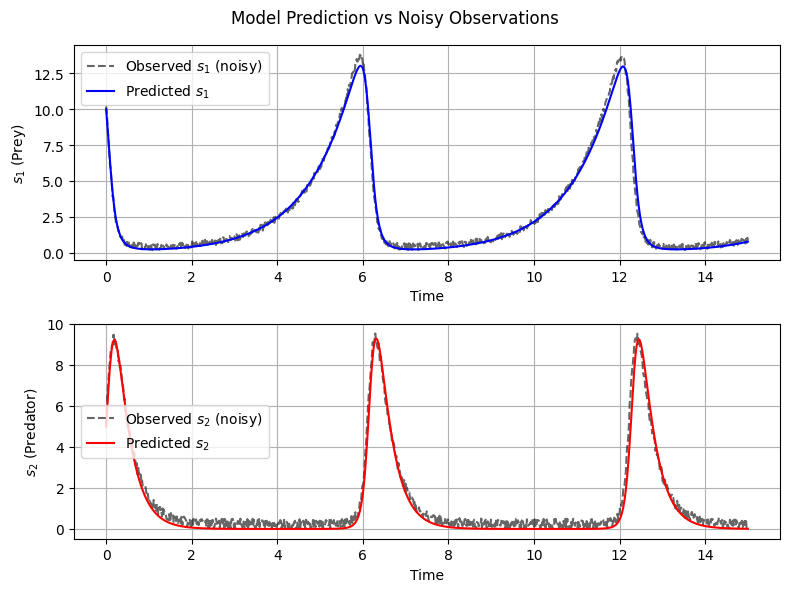

In [ ]:
def solve_lotka(p, t_eval=t_obs, s0=s0):
    sol = solve_ivp(lambda t, s: [
        p[0]*s[0] - p[1]*s[0]*s[1],
        -p[2]*s[1] + p[3]*s[0]*s[1]
    ], [t_eval[0], t_eval[-1]], s0, t_eval=t_eval)
    return sol.y.T  # shape (N, 2)

s_pred = solve_lotka(p_opt)

# check the truth
#p_true=np.array([1, 1, 3, 1])
#s_pred=solve_lotka(p_true)


# Plot observed (noisy) data and predicted model, one on top of the other
plt.figure(figsize=(8, 6))

# s1 (prey) on top
plt.subplot(2, 1, 1)
plt.plot(t_obs, s_obs[:, 0], 'k--', label='Observed $s_1$ (noisy)', alpha=0.6)
plt.plot(t_obs, s_pred[:, 0], 'b-', label='Predicted $s_1$')
plt.xlabel('Time')
plt.ylabel('$s_1$ (Prey)')
plt.legend()
plt.grid(True)

# s2 (predator) below
plt.subplot(2, 1, 2)
plt.plot(t_obs, s_obs[:, 1], 'k--', label='Observed $s_2$ (noisy)', alpha=0.6)
plt.plot(t_obs, s_pred[:, 1], 'r-', label='Predicted $s_2$')
plt.xlabel('Time')
plt.ylabel('$s_2$ (Predator)')
plt.legend()
plt.grid(True)

plt.suptitle('Model Prediction vs Noisy Observations')
plt.tight_layout()
plt.show()


In [ ]:
print("First few values of s_obs[:, 0]:", s_obs[:5, 0])
print("First few values of s_obs[:, 1]:", s_obs[:5, 1])

First few values of s_obs[:, 0]: [10.18727006  9.85510441  9.09455132  8.35878334  7.46415959]
First few values of s_obs[:, 1]: [5.09256646 5.79962681 6.49139549 6.93185401 7.45151886]
